In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpl = tfp.layers

# Bijectors and normalising flows

 ## Coding tutorials
 #### [1. Bijectors](#coding_tutorial_1)
 #### [2. The TransformedDistribution class](#coding_tutorial_2)
 #### [3. Subclassing bijectors](#coding_tutorial_3)
 #### [4. Normalising flows](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Bijectors

In [3]:
# Define base distribution
normal = tfd.Normal(loc=0.,scale=1.)


In [3]:
# Sample from base distribution
n = 10000
z = normal.sample(n)


### Scale and shift bijector

In [4]:
# Define scale and shift

scale = 4.5
shift = 7


In [5]:
# Define chain bijector
scale_and_shift = tfb.Chain([tfb.Shift(shift), tfb.Scale(scale)])



In [6]:
# We can also use call methods
scale_transf = tfb.Scale(scale)
shift_transf = tfb.Shift(shift)
scale_and_shift = shift_transf(scale_transf)


In [7]:
# Apply the forward transformation

x = scale_and_shift.forward(z)


In [8]:
# Check the forward transformation
tf.norm(x - (scale*z +shift))


<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

#### Plots

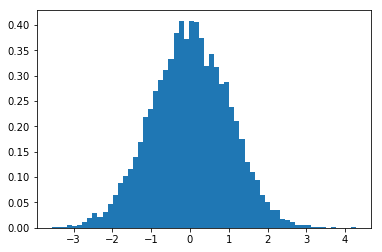

In [9]:
# Plot z density

plt.hist(z, bins=60, density=True)
plt.show()

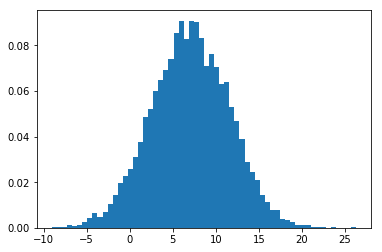

In [10]:
# Plot x density
plt.hist(x, bins=60, density=True)
plt.show()


#### Inverse transformation

In [11]:
# Apply inverse transformation

inv_x = scale_and_shift.inverse(x)

In [12]:
# Check inverse transformation

tf.norm(inv_x - z).numpy()

0.0

#### Log probability

In [13]:
# Compute log prob for x

log_prob_x = normal.log_prob(z) - scale_and_shift.forward_log_det_jacobian(z,event_ndims=0)#event_dims is zero because of scalar event space
print(log_prob_x)

tf.Tensor([-2.6562643 -2.4241426 -2.5887957 ... -4.4847636 -4.7611904 -2.9042172], shape=(10000,), dtype=float32)


In [14]:
# We can also use the inverse transformation

log_prob_x = normal.log_prob(scale_and_shift.inverse(x)) + scale_and_shift.inverse_log_det_jacobian(x, event_ndims=0)
print(log_prob_x)

tf.Tensor([-2.6562643 -2.4241426 -2.5887957 ... -4.4847636 -4.7611904 -2.9042172], shape=(10000,), dtype=float32)


### Broadcasting

In [15]:
x = tf.random.normal(shape=(100, 1))

In [16]:
# Softfloor bijector
softfloor = tfb.Softfloor(temperature=0.01)
y = softfloor.forward(x)
print(y.shape)


(100, 1)


In [17]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.2,1.])
y = softfloor.forward(x)
print(y.shape)

(100, 2)


In [18]:
# Softfloor bijector using broadcasting

softfloor = tfb.Softfloor(temperature=[0.01,0.1, 1.])

In [19]:
# Plot routine

def _plot(nparams, bijector, params, x):
    bijector_params = tuple(getattr(bijector, name) for name in params)
    upper_params = [name[0].upper() + name[1:] for name in params]
    fig = plt.figure(figsize=(14, 5))
    lines = plt.plot(np.tile(x, nparams), bijector.forward(x))
    for l in zip(lines, *bijector_params):
        labels = ": {:.2f}, ".join(upper_params) + ': {:.2f}'
        l[0].set_label(labels.format(*l[1:]))
    plt.legend()
    plt.show()

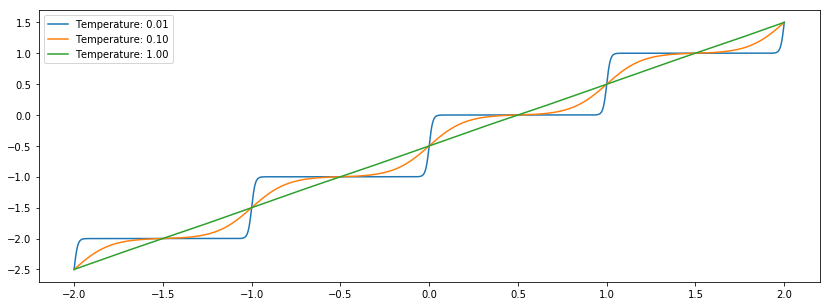

In [20]:
# Plot

x = np.linspace(-2, 2, 2000)[..., np.newaxis]
_plot(3,softfloor,['temperature'],x)

In [21]:
# Gumbel bijector using broadcasting

exps = tfb.GumbelCDF(loc=[0.5,1,1.5,2,3], scale=[1,2,2,3,4])

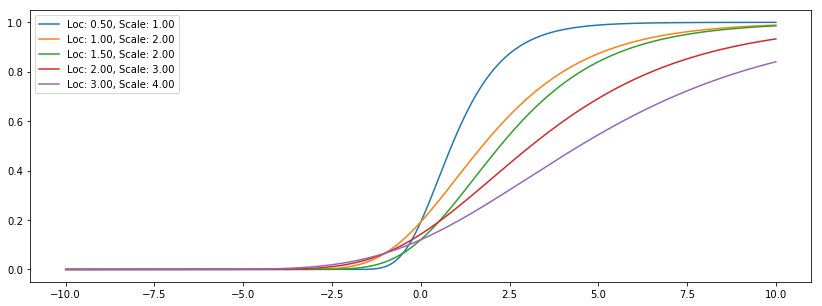

In [22]:
# Plot

x = np.linspace(-10, 10, 2000, dtype=np.float32)[..., np.newaxis]
_plot(5,exps,['loc','scale'],x)

***
<a id="coding_tutorial_2"></a>
## The TransformedDistribution class

### TransformedDistribution

In [23]:
# Parameters

n = 10000
loc = 0
scale = 0.5

In [24]:
# Normal distribution

normal = tfd.Normal(loc=loc, scale=scale)

In [25]:
# Display event and batch shape

print('batch shape: ', normal.batch_shape)
print('event shape: ', normal.event_shape)

batch shape:  ()
event shape:  ()


In [26]:
# Exponential bijector

exp = tfb.Exp()

In [27]:
# Log normal transformed distribution using exp and normal bijectors
log_normal_td = exp(normal)



In [28]:
# Display event and batch shape
print('batch shape: ', log_normal_td.batch_shape)
print('event shape: ', log_normal_td.event_shape)


batch shape:  ()
event shape:  ()


In [29]:
# Base distribution

z = normal.sample(n)

In [30]:
z

<tf.Tensor: shape=(10000,), dtype=float32, numpy=
array([-3.5874143e-01,  4.8225250e-02,  1.1995599e+00, ...,
       -9.9189172e-04,  2.2699042e-01, -1.1503260e-01], dtype=float32)>

#### Plots

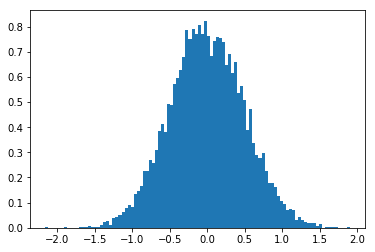

In [31]:
# Plot z density

plt.hist(z,bins=100, density=True)
plt.show()

In [32]:
# Transformed distribution
x = log_normal_td.sample(n)


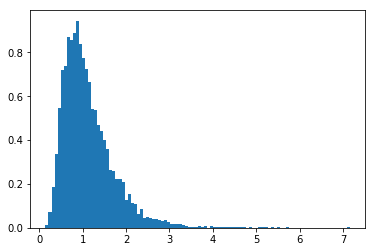

In [33]:
# Plot x density
plt.hist(x,bins=100, density=True)
plt.show()


In [34]:
# Define log normal distribution

log_normal = tfd.LogNormal(loc=loc, scale=scale)

In [35]:
# Sample log_normal
l = log_normal.sample(n)


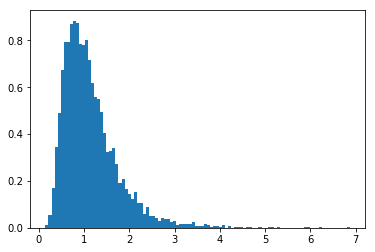

In [36]:
# Plot l density
plt.hist(l,bins=100, density=True)
plt.show()


#### Log probability

In [37]:
# Log prob of LogNormal

log_prob = log_normal.log_prob(x)

In [38]:
# Log prob of log normal transformed distribution

log_prob_td = log_normal_td.log_prob(x)

In [39]:
# Check log probs

tf.norm(log_prob_td - log_prob) # almost same

<tf.Tensor: shape=(), dtype=float32, numpy=7.3938895e-06>

### Event shape and batch shape

In [121]:
# Set a scaling lower triangular matrix

tril = tf.random.normal((2,4,4))
scale_low_tri = tf.linalg.LinearOperatorLowerTriangular(tril) # Ignores the upper triangle

In [122]:
# View of scale_low_tri

scale_low_tri.to_dense()

<tf.Tensor: shape=(2, 4, 4), dtype=float32, numpy=
array([[[ 1.0364509 ,  0.        ,  0.        ,  0.        ],
        [-0.9646656 , -0.5484339 ,  0.        ,  0.        ],
        [-1.5961326 ,  1.3300786 ,  0.8343394 ,  0.        ],
        [ 0.21832022,  1.0285525 , -0.6569771 , -1.2548121 ]],

       [[-1.6512986 ,  0.        ,  0.        ,  0.        ],
        [ 0.02514087,  0.5452045 ,  0.        ,  0.        ],
        [-1.2323664 ,  0.97995687, -1.1076746 ,  0.        ],
        [ 1.0119773 ,  0.18356733,  1.2188989 ,  1.1614425 ]]],
      dtype=float32)>

In [123]:
# Define scale linear operator

scale_lin_op = tfb.ScaleMatvecLinearOperator(scale_low_tri)

In [127]:
# Define scale linear operator transformed distribution with a batch and event shape

mvn = tfd.TransformedDistribution( tfd.Normal(loc=0, scale=1),scale_lin_op,batch_shape=[2],event_shape=[4])
print(mvn)

tfp.distributions.TransformedDistribution("scale_matvec_linear_operatorNormal", batch_shape=[2], event_shape=[4], dtype=float32)


In [125]:
# Display event and batch shape

print("event shape",mvn.event_shape)
print("batch shape",mvn.batch_shape)

event shape ()
batch shape ()


In [126]:
# Sample

y1 = mvn.sample()
print(y1.shape)

IndexError: list index out of range

In [46]:
# Define a MultivariateNormalLinearOperator distribution

mvn2 = tfd.MultivariateNormalLinearOperator(loc=0.0,scale=scale_low_tri)
print(mvn2)

tfp.distributions.MultivariateNormalLinearOperator("MultivariateNormalLinearOperator", batch_shape=[2], event_shape=[4], dtype=float32)


In [47]:
# Display event and batch shape

print("event shape",mvn2.event_shape)
print("batch shape",mvn2.batch_shape)

event shape (4,)
batch shape (2,)


In [48]:
# Sample

y2 = mvn2.sample(sample_shape=(n,))
print(y2.shape)

(10000, 2, 4)


In [49]:
# Check

xn = normal.sample((1,2,4))
tf.norm(mvn.log_prob(xn)-mvn2.log_prob(xn))#/tf.norm(mvn.log_prob(xn))

<tf.Tensor: shape=(), dtype=float32, numpy=0.0>

In [50]:
mvn.log_prob(xn),mvn2.log_prob(xn)

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-2.6696455e+00, -4.5667145e+04]], dtype=float32)>,
 <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[-2.6696455e+00, -4.5667145e+04]], dtype=float32)>)

##### My custom test

In [51]:
xn = normal.sample((2,4))

###### The following shows that when the input tensor hass no batch dimension (4,), the input is broadcasted to match batch size of the bijector (2 here). In this case, the same tensor is transformed by the two different bijection matrices.


In [52]:

print(mvn2.log_prob(xn[0]))
print(mvn2.log_prob(tf.stack([xn[0],xn[0]])))
mvn2.log_prob(tf.stack([xn[0],xn[0]]))-mvn2.log_prob(xn[0])

tf.Tensor([-1.3546390e+01 -2.9732544e+05], shape=(2,), dtype=float32)
tf.Tensor([-1.3546390e+01 -2.9732544e+05], shape=(2,), dtype=float32)


<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0., 0.], dtype=float32)>

##### Similarly no broadcast happens when batc dimension of the input tensor matches with the bijector batch dimension. In this case, two different tensors are transformed by the two different bijection matrices.
Notice how the second probability is different compared to the above case. Thats due to second bijective recieving different tensor.


In [53]:
mvn2.log_prob(xn)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([-1.3546390e+01, -2.4645497e+05], dtype=float32)>

***
<a id="coding_tutorial_3"></a>
## Subclassing bijectors

In [4]:
# Define a new bijector: Cubic

class Cubic(tfb.Bijector):

    def __init__(self, a, b, validate_args=False, name='Cubic'):
        self.a = tf.cast(a, tf.float32)
        self.b = tf.cast(b, tf.float32)
        if validate_args:
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.a), 1e-5), tf.float32)) == 1.0
            assert tf.reduce_mean(tf.cast(tf.math.greater_equal(tf.abs(self.b), 1e-5), tf.float32)) == 1.0
        super(Cubic, self).__init__(
            validate_args=validate_args, forward_min_event_ndims=0, name=name)

    def _forward(self,x):
       # print("a",self.a)
       # print("b", self.b)
        x = tf.cast(x, tf.float32)
        return tf.squeeze(tf.pow(self.a*x+self.b ,3))
    
    def _inverse(self,y):
        y = tf.cast(y, tf.float32)
        return (tf.math.sign(y)*tf.pow(tf.abs(y),1/3) - self.b) / self.a
    
    def _forward_log_det_jacobian(self, x):
        x = tf.cast(x, tf.float32)
        return tf.math.log(3*tf.abs(self.a))+2. * tf.math.log(tf.abs(self.a*x+self.b))

In [5]:
# Cubic bijector

#tf.math.pow(1,tf.constant(1/3))
cubic = Cubic([1.,-2.],
              [-1,0.4], validate_args=True)


In [14]:
# Apply forward transformation
x = tf.constant([[1,2],[3,4]])
print(x.shape)
y = cubic.forward(x)
print(y)
-7.6**3

(2, 2)
tf.Tensor(
[[   0.       -46.656  ]
 [   8.      -438.97598]], shape=(2, 2), dtype=float32)


-438.97599999999994

In [7]:
x = tf.constant(1)
y = cubic.forward(x)
print(y)
-1.6**3

tf.Tensor([ 0.    -4.096], shape=(2,), dtype=float32)


-4.096000000000001

In [8]:
# Check inverse

np.linalg.norm(x - cubic.inverse(y))

0.0

#### Function plots

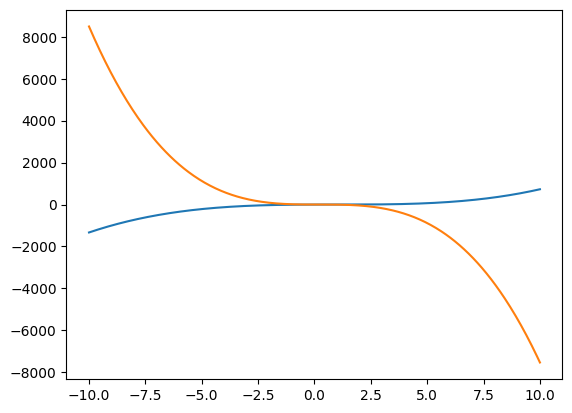

In [9]:
# Plot the forward transformation

x = np.linspace(-10, 10, 500).reshape(-1, 1)
plt.plot(x, cubic.forward(x))

In [60]:
# Display shape

print(cubic.forward(x).shape)

(500, 2)


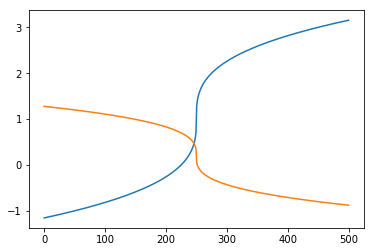

In [61]:
# Plot the inverse

plt.plot(cubic.inverse(x))

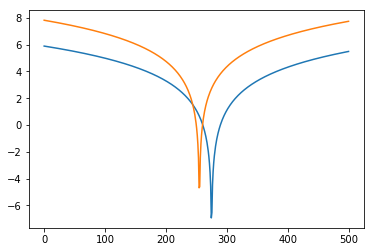

In [62]:
# Plot the forward log Jacobian determinant

plt.plot(cubic.forward_log_det_jacobian(x, event_ndims=0))

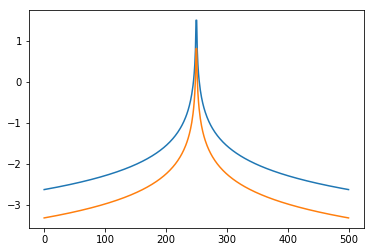

In [63]:
# Plot the inverse log Jacobian determinant

plt.plot(cubic.inverse_log_det_jacobian(x, event_ndims=0))

#### TransformedDistribution and plots

In [64]:
# Create a transformed distribution with Cubic
normal = tfd.Normal(loc=0., scale=1.)
cubed_normal = tfd.TransformedDistribution(normal, cubic, event_shape=[2])
cubed_normal

<tfp.distributions.TransformedDistribution 'CubicNormal' batch_shape=[] event_shape=[2] dtype=float32>

In [65]:
# Sample cubed_normal
n = 1000
g = cubed_normal.sample(n)


In [66]:
# Print the thre transformed samples,and the base samples using inverse transformation
print(g[:1])
print(g.shape)
print(cubed_normal.bijector.inverse(g[:1]))

tf.Tensor([[-0.5318065 -7.365766 ]], shape=(1, 2), dtype=float32)
(1000, 2)
tf.Tensor([[0.18981433 1.1728427 ]], shape=(1, 2), dtype=float32)


In [67]:
# The following confirms that events of shape (2,) are sampled. Each component of event is then transformed by a separate value of a and b in the cubic transformation
print((-2.4391038*1 -1)**3)
print((-1.7565025*-2 +.4)**3)

-40.67577647108041
59.91439917082848


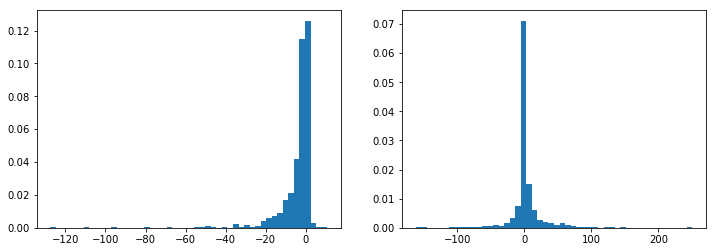

In [68]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

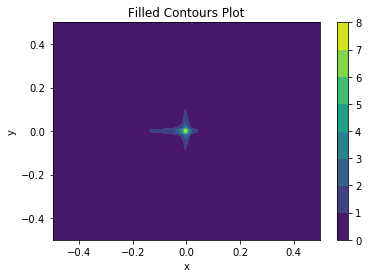

In [69]:
# Make contour plot

xx = np.linspace(-0.5, 0.5, 100)
yy = np.linspace(-0.5, 0.5, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

In [70]:
# Create a transformed distribution with the inverse of Cube

inverse_cubic = tfb.Invert(cubic)
#print(type(inverse_cubic))
inv_cubed_normal = inverse_cubic(normal, event_shape=[2])
#print("\n",inv_cubed_normal)

In [71]:
# Samble inv_cubed_normal
n = 1000
g = inv_cubed_normal.sample(n)
g.shape


TensorShape([1000, 2])

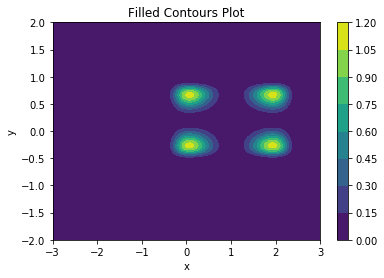

In [72]:
# Make contour plot

xx = np.linspace(-3.0, 3.0, 100)
yy = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xx, yy)

fig,ax=plt.subplots(1,1)
Z = inv_cubed_normal.prob(np.dstack((X, Y)))
cp = ax.contourf(X, Y, Z)
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.show()

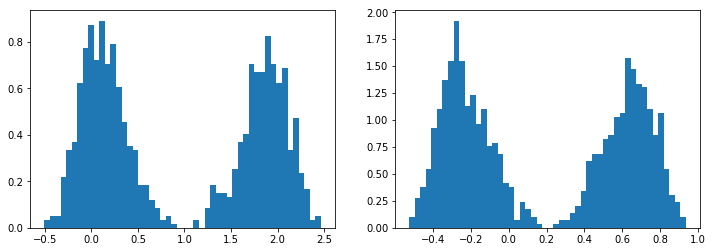

In [73]:
# Plot histograms

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(g[..., 0], bins=50, density=True)
plt.subplot(1, 2, 2)
plt.hist(g[..., 1], bins=50, density=True)
plt.show()

#### Training the bijector

In [74]:
# Create a mixture of four Gaussians
probs = [0.45, 0.55]
mix_gauss = tfd.Mixture(
    cat = tfd.Categorical(probs=probs),
    components=[
        tfd.Normal(loc=2.3, scale=0.4),
        tfd.Normal(loc=-0.8, scale=0.4)
])


In [75]:
# Create the dataset

x_train = mix_gauss.sample(10000)
x_train = tf.data.Dataset.from_tensor_slices(x_train)
x_train = x_train.batch(128)

x_valid = mix_gauss.sample(1000)
x_valid = tf.data.Dataset.from_tensor_slices(x_valid)
x_valid = x_valid.batch(128)

print(x_train.element_spec)
print(x_valid.element_spec)

TensorSpec(shape=(None,), dtype=tf.float32, name=None)
TensorSpec(shape=(None,), dtype=tf.float32, name=None)


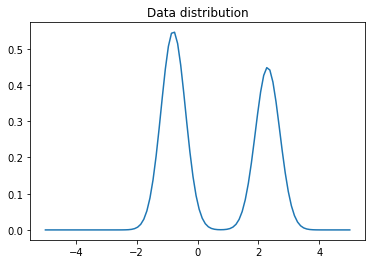

In [76]:
# Plot the data distribution
x = np.linspace(-5,5,100)
plt.plot(x, mix_gauss.prob(x))
plt.title('Data distribution')
plt.show()


In [77]:
# Make a trainable bijector

trainable_inv_cubic = tfb.Invert(Cubic(tf.Variable(0.25),tf.Variable(-0.1)))
trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.25>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.1>)

In [78]:
# Make a trainable transformed distribution
trainable_dist = tfd.TransformedDistribution(normal, trainable_inv_cubic)


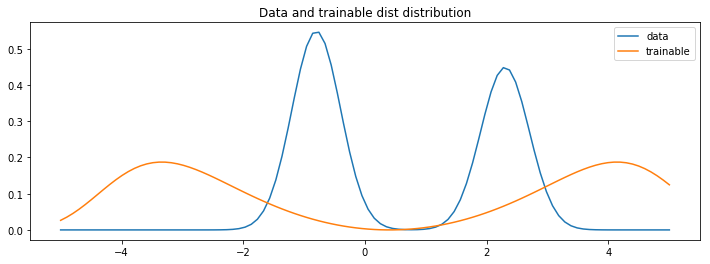

In [79]:
# Plot the data and learned distributions

x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x),label='data')
plt.plot(x, trainable_dist.prob(x),label='trainable')
plt.legend()
plt.title('Data and trainable dist distribution')
plt.show()


In [80]:
# Train the bijector

num_epochs = 10
opt = tf.keras.optimizers.Adam()
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    print("Epoch {}...".format(epoch))
    train_loss = tf.keras.metrics.Mean()
    val_loss = tf.keras.metrics.Mean()
    for train_batch in x_train:
        with tf.GradientTape() as tape:
            tape.watch(trainable_inv_cubic.trainable_variables)
            loss = -trainable_dist.log_prob(train_batch)
        train_loss(loss)
        grads = tape.gradient(loss, trainable_inv_cubic.trainable_variables)
        opt.apply_gradients(zip(grads, trainable_inv_cubic.trainable_variables))
    train_losses.append(train_loss.result().numpy())
        
    # Validation
    for valid_batch in x_valid:
        loss = -trainable_dist.log_prob(valid_batch)
        val_loss(loss)
    valid_losses.append(val_loss.result().numpy())

Epoch 0...
Epoch 1...
Epoch 2...
Epoch 3...
Epoch 4...
Epoch 5...
Epoch 6...
Epoch 7...
Epoch 8...
Epoch 9...


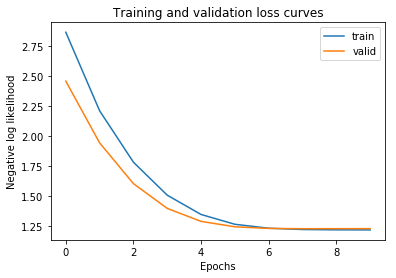

In [81]:
# Plot the learning curves

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

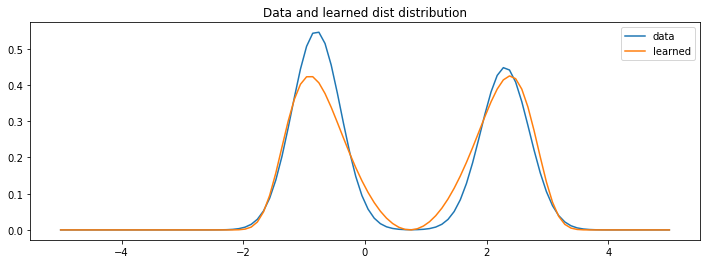

In [82]:
# Plot the data and learned distributions
x = np.linspace(-5,5,100)
plt.figure(figsize=(12,4))
plt.plot(x, mix_gauss.prob(x),label='data')
plt.plot(x, trainable_dist.prob(x),label='learned')
plt.legend()
plt.title('Data and learned dist distribution')
plt.show()



In [83]:
# Display trainable variables

trainable_inv_cubic.trainable_variables

(<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.5674223>,
 <tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.41908863>)

***
<a id="coding_tutorial_4"></a>
## Normalising flows

__Notes__
In this tutorial we will deal woth masked autoregressive flow

In [84]:
# Load dataset

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
n_samples = 1000
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
X, y = noisy_moons
X_data = StandardScaler().fit_transform(X)
xlim, ylim = [-2, 2], [-2, 2]

(-2, 2)

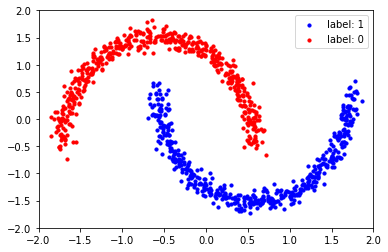

In [85]:
# Plot with labels

y_label = y.astype(np.bool)
X_train, Y_train = X_data[..., 0], X_data[..., 1]
plt.scatter(X_train[y_label], Y_train[y_label], s=10, color='blue')
plt.scatter(X_train[y_label == False], Y_train[y_label == False], s=10, color='red')
plt.legend(['label: 1', 'label: 0'])
plt.xlim(xlim)
plt.ylim(ylim)

In [86]:
print(X.shape, y.shape)

(1000, 2) (1000,)


In [87]:
# Define base distribution

base_distribution = tfd.Normal(loc=0, scale=1)

In [88]:
# Define the trainable distribution
def make_masked_autoregressive_flow(hidden_units=[16, 16], activation='relu'):
    made = tfb.AutoregressiveNetwork(
    params=2, event_shape=[2], hidden_units=hidden_units, activation=activation)
    return tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn=made)

trainable_distribution = tfd.TransformedDistribution(base_distribution, make_masked_autoregressive_flow(), event_shape=[2])

In [89]:
trainable_distribution.trainable_variables

()

In [90]:
trainable_distribution.sample(2)

Instructions for updating:
`AffineScalar` bijector is deprecated; please use `tfb.Shift(loc)(tfb.Scale(...))` instead.


<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0.77066445,  0.91342884],
       [-0.5793188 , -1.3090488 ]], dtype=float32)>

In [91]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tensorflow.compat.v1 import logging
logging.set_verbosity(logging.ERROR)

In [92]:
# Define a plot contour routine

def plot_contour_prob(dist, rows=1, title=[''], scale_fig=4):
    cols = int(len(dist) / rows)
    xx = np.linspace(-5.0, 5.0, 100)
    yy = np.linspace(-5.0, 5.0, 100)
    X, Y = np.meshgrid(xx, yy)

    fig, ax = plt.subplots(rows, cols, figsize=(scale_fig * cols, scale_fig * rows))
    fig.tight_layout(pad=4.5)

    i = 0
    for r in range(rows):
        for c in range(cols):
            Z = dist[i].prob(np.dstack((X, Y)))
            if len(dist) == 1:
                axi = ax
            elif rows == 1:
                axi = ax[c]
            else:
                axi = ax[r, c]

            # Plot contour
            p = axi.contourf(X, Y, Z)

            # Add a colorbar
            divider = make_axes_locatable(axi)
            cax = divider.append_axes("right", size="5%", pad=0.1)
            cbar = fig.colorbar(p, cax=cax)

            # Set title and labels
            axi.set_title('Filled Contours Plot: ' + str(title[i]))
            axi.set_xlabel('x')
            axi.set_ylabel('y')

            i += 1
    plt.show()

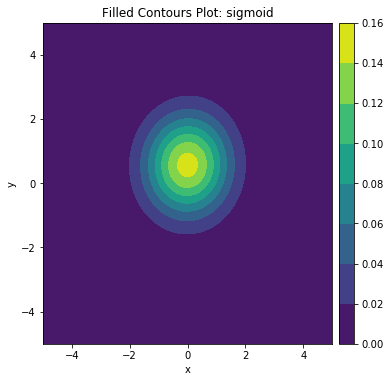

In [93]:
# Plot contour
activation = 'sigmoid'
maf = tfd.TransformedDistribution(base_distribution, make_masked_autoregressive_flow(activation=activation), event_shape=[2])
plot_contour_prob([maf], scale_fig=6, title=[activation])

In [94]:
from tensorflow.keras.layers import Input
from tensorflow.keras import Model

In [95]:
# Make samples
x = base_distribution.sample((1000,2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]

In [96]:
# Define a scatter plot routine for the bijectors

def _plot(results, rows=1, legend=False):
    cols = int(len(results) / rows)
    f, arr = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))
    i = 0
    for r in range(rows):
        for c in range(cols):
            res = results[i]
            X, Y = res[..., 0].numpy(), res[..., 1].numpy()
            if rows == 1:
                p = arr[c]
            else:
                p = arr[r, c]
            p.scatter(X, Y, s=10, color='red')
            p.set_xlim([-5, 5])
            p.set_ylim([-5, 5])
            p.set_title(names[i])
            
            i += 1

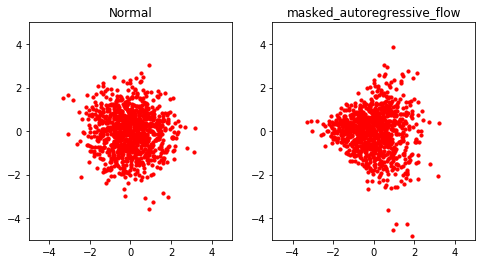

In [97]:
# Plot

_plot(samples)

#### Training a MaskedAutoregressiveFlow bijector

In [98]:
from tensorflow.keras.callbacks import LambdaCallback

In [99]:
# Define a training routine

def train_dist_routine(trainable_distribution, n_epochs=200, batch_size=None, n_disp=100):
    x_ = Input(shape=(2,), dtype=tf.float32)
    log_prob_ = trainable_distribution.log_prob(x_)
    model = Model(x_, log_prob_)

    model.compile(optimizer=tf.optimizers.Adam(),
                  loss=lambda _, log_prob: -log_prob)

    ns = X_data.shape[0]
    if batch_size is None:
        batch_size = ns

    # Display the loss every n_disp epoch
    epoch_callback = LambdaCallback(
        on_epoch_end=lambda epoch, logs: 
                        print('\n Epoch {}/{}'.format(epoch+1, n_epochs, logs),
                              '\n\t ' + (': {:.4f}, '.join(logs.keys()) + ': {:.4f}').format(*logs.values()))
                                       if epoch % n_disp == 0 else False 
    )


    history = model.fit(x=X_data,
                        y=np.zeros((ns, 0), dtype=np.float32),
                        batch_size=batch_size,
                        epochs=n_epochs,
                        validation_split=0.2,
                        shuffle=True,
                        verbose=False,
                        callbacks=[epoch_callback])
    return history

In [100]:
# Train the distribution
1
history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)


 Epoch 1/600 
	 loss: 2.9289, val_loss: 2.8716

 Epoch 51/600 
	 loss: 2.7502, val_loss: 2.6898

 Epoch 101/600 
	 loss: 2.7073, val_loss: 2.6453

 Epoch 151/600 
	 loss: 2.6730, val_loss: 2.6062

 Epoch 201/600 
	 loss: 2.6422, val_loss: 2.5778

 Epoch 251/600 
	 loss: 2.6077, val_loss: 2.5511

 Epoch 301/600 
	 loss: 2.5599, val_loss: 2.5152

 Epoch 351/600 
	 loss: 2.4865, val_loss: 2.4626

 Epoch 401/600 
	 loss: 2.3830, val_loss: 2.3905

 Epoch 451/600 
	 loss: 2.2506, val_loss: 2.2951

 Epoch 501/600 
	 loss: 2.1619, val_loss: 2.2289

 Epoch 551/600 
	 loss: 2.1205, val_loss: 2.2001


In [101]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

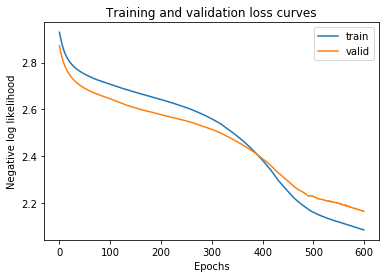

In [102]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [103]:
# Make samples
x = base_distribution.sample((1000,2))
names = [base_distribution.name, trainable_distribution.bijector.name]
samples = [x, trainable_distribution.bijector.forward(x)]


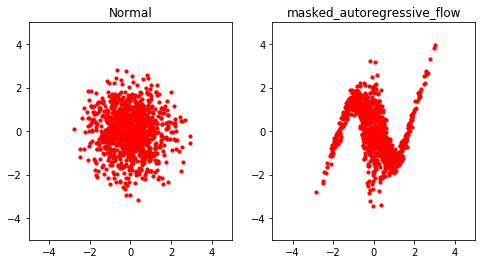

In [104]:
# Plot
_plot(samples)


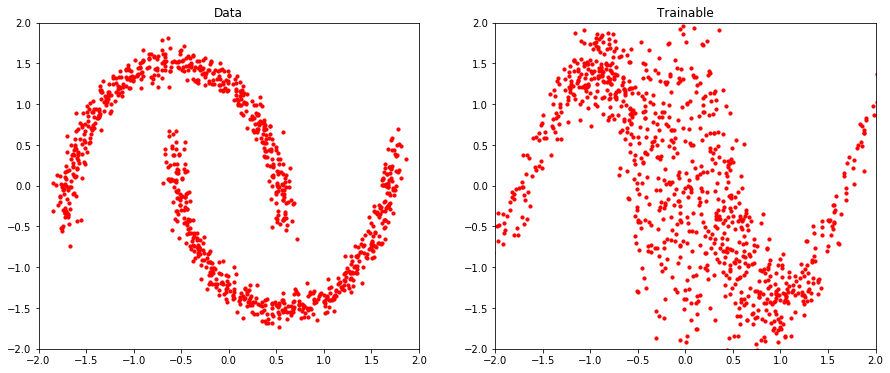

In [105]:
# Define a plot routine

def visualize_training_data(samples):
    f, arr = plt.subplots(1, 2, figsize=(15, 6))
    names = ['Data', 'Trainable']
    samples = [tf.constant(X_data), samples[-1]]

    for i in range(2):
        res = samples[i]
        X, Y = res[..., 0].numpy(), res[..., 1].numpy()
        arr[i].scatter(X, Y, s=10, color='red')
        arr[i].set_xlim([-2, 2])
        arr[i].set_ylim([-2, 2])
        arr[i].set_title(names[i])

visualize_training_data(samples)

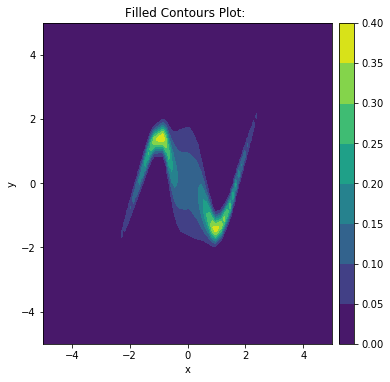

In [106]:
# Plot contour

plot_contour_prob([trainable_distribution], scale_fig=6)

#### Training a chain of MaskedAutoregressiveFlow bijectors

In [107]:
# Define a more expressive model
num_bijectors=6
bijectors = []
for i in range(num_bijectors):
    masked_auto_i = make_masked_autoregressive_flow(hidden_units=[256,256], activation='relu')
    bijectors.append(masked_auto_i)
    bijectors.append(tfb.Permute(permutation=[1,0]))

    
flow_bijector = tfb.Chain(list(reversed(bijectors[:-1])))

In [108]:
# Define the trainable distribution

trainable_distribution = tfd.TransformedDistribution(base_distribution, flow_bijector, event_shape=[2])

In [109]:
print(trainable_distribution.bijector.bijectors)

ListWrapper([<tensorflow_probability.python.bijectors.masked_autoregressive.MaskedAutoregressiveFlow object at 0x79ed18291160>, <tensorflow_probability.python.bijectors.permute.Permute object at 0x79ed1833c6a0>, <tensorflow_probability.python.bijectors.masked_autoregressive.MaskedAutoregressiveFlow object at 0x79ed1833c860>, <tensorflow_probability.python.bijectors.permute.Permute object at 0x79ed1833c048>, <tensorflow_probability.python.bijectors.masked_autoregressive.MaskedAutoregressiveFlow object at 0x79ed1833c828>, <tensorflow_probability.python.bijectors.permute.Permute object at 0x79ed182e4a20>, <tensorflow_probability.python.bijectors.masked_autoregressive.MaskedAutoregressiveFlow object at 0x79ed182e4b70>, <tensorflow_probability.python.bijectors.permute.Permute object at 0x79ed182e4978>, <tensorflow_probability.python.bijectors.masked_autoregressive.MaskedAutoregressiveFlow object at 0x79ed182e4dd8>, <tensorflow_probability.python.bijectors.permute.Permute object at 0x79ed182

In [110]:
# Make samples

def make_samples():
    x = base_distribution.sample((1000, 2))
    samples = [x]
    names = [base_distribution.name]
    for bijector in reversed(trainable_distribution.bijector.bijectors):
        x = bijector.forward(x)
        samples.append(x)
        names.append(bijector.name)
    return names, samples

names, samples = make_samples()

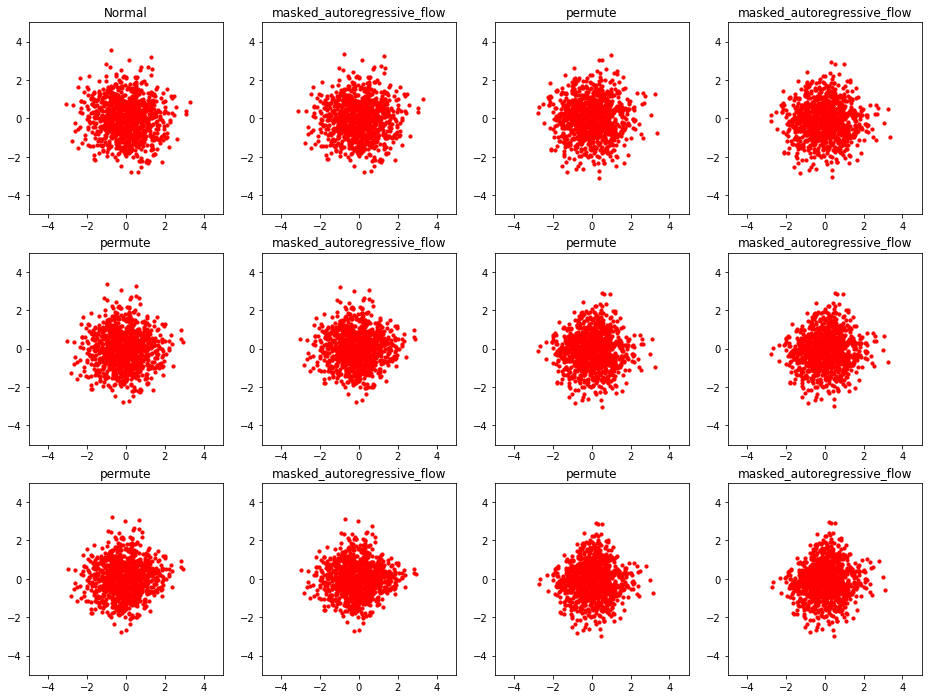

In [111]:
# Plot

_plot(samples,3)

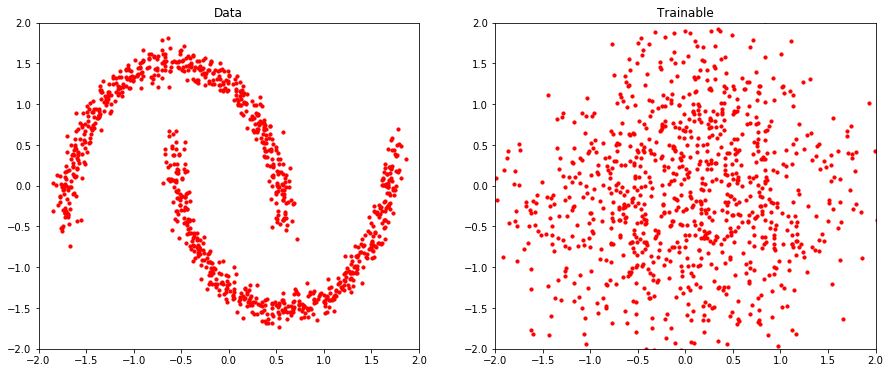

In [112]:
# Plot

visualize_training_data(samples)

In [113]:
# Train the distribution
history = train_dist_routine(trainable_distribution, n_epochs=600, n_disp=50)



 Epoch 1/600 
	 loss: 3.0255, val_loss: 2.6362


KeyboardInterrupt: 

In [ ]:
# Get losses

train_losses = history.history['loss']
valid_losses = history.history['val_loss']

In [ ]:
# Plot loss vs epoch

plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Negative log likelihood")
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Make samples and plot

names, samples = make_samples()
_plot(samples,3)

In [ ]:
# Plot

visualize_training_data(samples)

In [ ]:
# Plot

plot_contour_prob([trainable_distribution], scale_fig=6)